# Spatial mapping of cell types across the mouse brain (3/3) - visualising results and downstream analysis

This notebook demonstrates how to use the **cell2location** model for mapping a single cell transcriptomic reference onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain (Kleshchevnikov et al., in preparation). 

cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and multi-cell spatial transcriptomics to map cell types at scale (Fig below). cell2location leverages reference signatures that are estimated from scRNA-seq profiles, for example using conventional clustering followed by estimation of average gene expression profiles. Based on these reference signatures, mRNA contributions from each of the defined cell types are estimated at each location in the spatial data, which gives rise to both cell type proportions as well as absolute densities of cell types in a spatially resolved manner. In this notebook, we examine and use estimated cell densities of cell types to perform downstream analysis. 

![Fig1](../images/Fig1_v2.png)   
Fig 1. Cell2location model for spatial mapping of comprehensive cell type references.    
A. Overview  of the spatial mapping workflow that is enabled by cell2location. Spatial transcriptomics data are decomposed into cell type abundance estimates, using a scRNA-seq based cell type reference from the same tissue.    
B. Basic principles of the strategy employed by cell2location.  

## Outline

The **cell2location** workflow consists of three sections:


I. Estimating reference expression signatures of cell types (1/3, this notebook):

1. Loading single cell reference data
2. Reduce the number of genes by discarding lowly expressed genes
3. Exploring the data: show UMAP of cells
4. Estimating expression signatures
5. Additional quality control: removing technical effects and performing standard scanpy single cell analysis workflow

II. Spatially mapping cell types (2/3):

1. Loading Visium data and single cell reference, QC
2. Exploring the data: UMAP of cells and locations
3. cell2location analysis pipeline

III. Results and downstream analysis (3/3):

1. [Loading cell2location results](#1.-Loading-cell2location-results)
2. [Visialising cell locations](#2.-Visualisation-of-cell-locations)
3. [Automatic discrete region identification by clustering cell densities](#3.-Automatic-discrete-region-identification-by-clustering-cell-densities)
4. [Identify co-occuring cell type groups using matrix factorisation](#5.-Identify-co-occuring-cell-type-groups-using-matrix-factorisation)
5. [Visualize cell type density gradients using diffusion maps](#5.-Visualize-cell-type-density-gradients-using-diffusion-maps)


## Loading packages

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os

sys.path.insert(1, '../../')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading cell2location results <a name="loading"></a>

First, let's load the cell2location results. In the export step of the cell2location pipeline, cell locations are added to `sp_data` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are saved to the results directory. 

We load the results of the model saved into the `adata_vis` Anndata object with spatial data :

In [2]:
results_folder = '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/'
r = {'run_name': 'LocationModelLinearDependentWMultiExperiment_58clusters_5396locations_12809genes'}

sp_data_file = results_folder + 'std_model/'+r['run_name']+'/sp.h5ad'

adata_vis = anndata.read(sp_data_file)

Alternatively, we can load our model after training. When `'save_model': True`, the trained model `r['mod']` is saved as a pickle file. You can load the model later and continue training. Ff the training was done on a GPU, the model needs to be loaded on a GPU.

```python
pickle_model = results_folder + 'std_model/'+r['run_name']+'/model_.p'
r = pickle.load(open(pickle_model, "rb"))

# model
mod = r['mod']

# anndata object with input data and results
adata_vis = r['sp_data']
```

## 2. Visualisation of cell locations <a name="visualisation"></a>

First, we learn how to visualise cell type locations using the standard scanpy pipeline and our custom script that maps several cell types at once.

Our model outputs the absolute density of cells across locations in two different ways:    
1. Using location weights representing absolute density of cells. This estimation relies on the priors on the number of cells, number of cell types and the average change in sensitivity between technologies.    
2. Using estimated absolute mRNA counts from each cell type. These estimates do not rely on the priors to get the scale right so the values are very robust. Absolute mRNA count = UMI (Unique Molecular Identifier) count.   

For both of these measures, the posterior mean and 5% quantile are used to visualise the results. Posterior mean shows the most likely value while 5% quantile show the density of cells and the mRNA count confidently assigned to each cell type.

For each visium section, 4 panels showing the locations of regulatory programmes of all cell types are plotted and saved to `run name /plots/spatial/`.

Here, we visualise locations of multiple cell types at once using absolute cell density (5% quantile). Six neuronal and glial cell types mapping to different regions of the mouse brain are shown.

Trying to set attribute `.uns` of view, copying.


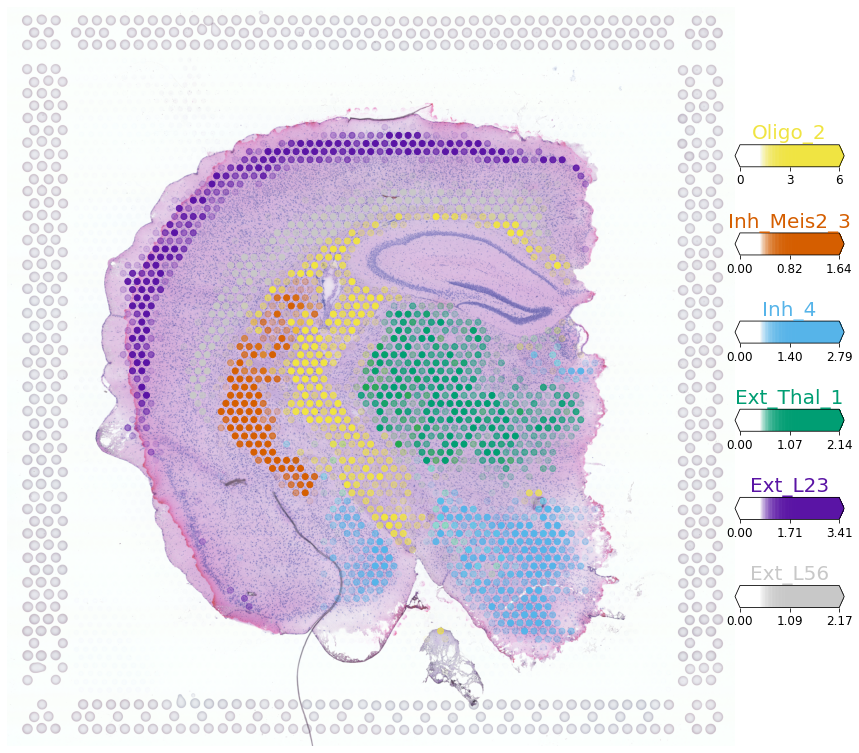

In [3]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 6 clusters 
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

slide = select_slide(adata_vis, 'ST8059048')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.8,
                  style='fast', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=6, colorbar_position='right')

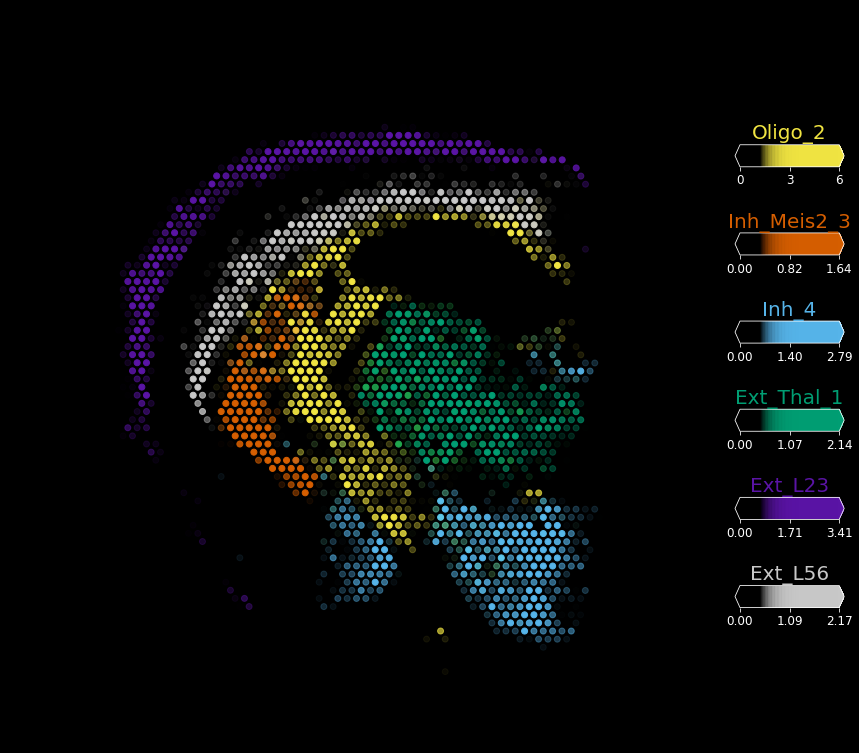

In [4]:
with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0,
                  style='dark_background', # fast or dark_background
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=6, colorbar_position='right')

Now, we plot the 5% quantile of the posterior distribution on the number of UMI which shows the mRNA count assigned to each cell type with high confidence. This is often useful for troubleshooting, because low mRNA counts generally reflect failure to map at cell type (e.g. less than 50 UMI on max value on the color scale).

Trying to set attribute `.uns` of view, copying.


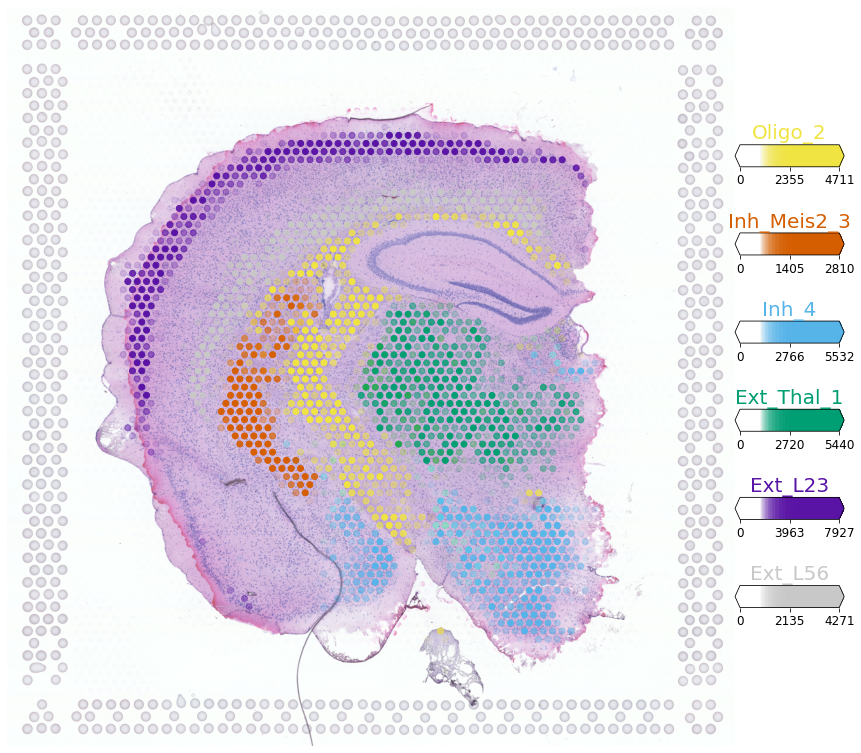

In [4]:
# select up to 6 clusters 
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['q05_nUMI_factors' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(slide.obs[sel_clust_col], labels=sel_clust,
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.8,
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  circle_diameter=6,  colorbar_position='right')

Next, we use the standard scanpy pipeline to plot cell locations over histology images:
1. Using location weights representing absolute density of cells - linear scale
1. Using location weights representing absolute density of cells - log10 scale
2. Using estimated absolute mRNA count from each cell type

Trying to set attribute `.uns` of view, copying.


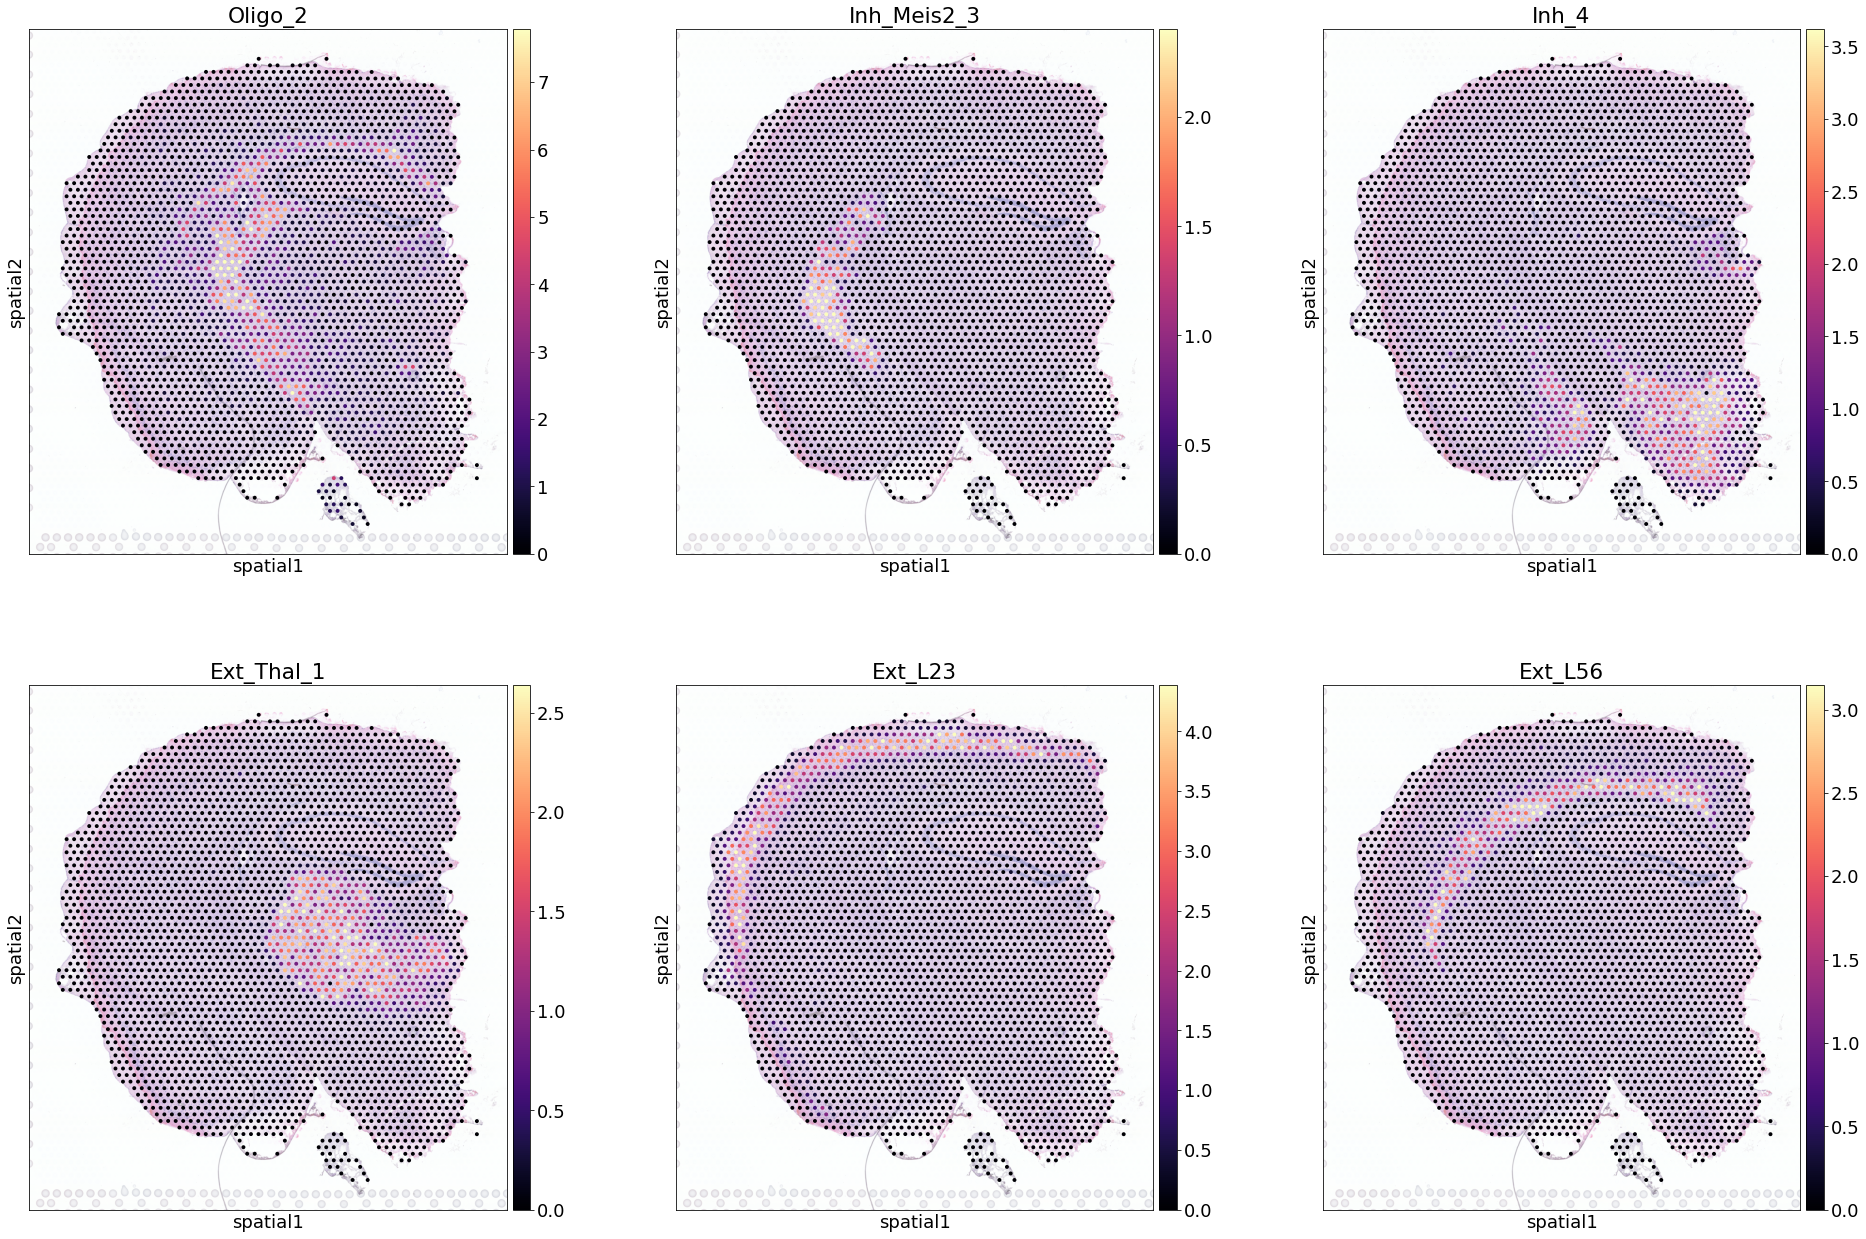

In [5]:
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

slide = select_slide(adata_vis, 'ST8059048')

# plot with nice names
with mpl.rc_context({'figure.figsize': (10, 10), "font.size": 18}):
    slide.obs[sel_clust] = (slide.obs[sel_clust_col])
    sc.pl.spatial(slide, cmap='magma',
                  color=sel_clust[0:6], # limit size in this notebook
                  ncols=3, 
                  size=0.8, img_key='hires', 
                  alpha_img=0.5,
                  vmin=0, vmax='p99.2'
                 )

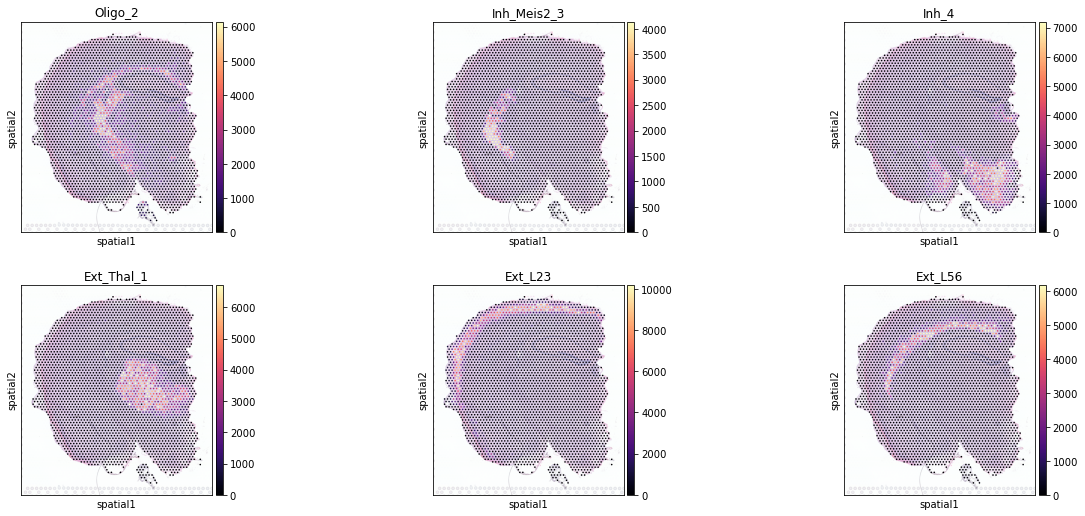

In [6]:
# plot nUMI from each cluster
sel_clust_col = ['q05_nUMI_factors' + str(i) for i in sel_clust]
slide.obs[sel_clust] = (slide.obs[sel_clust_col])
sc.pl.spatial(slide, cmap='magma',
              color=sel_clust[0:6], # limit size in this notebook
              ncols=3, 
              size=0.8, img_key='hires', 
              alpha_img=0.5,
              vmin=0, vmax='p99.2'
             )

## 3. Automatic discrete region identification by clustering cell densities <a name="identification"></a>

We can identify tissue regions that differ in their cell composition by examining the cell type lcoations inferred by cell2location. 

We find tissue regions by clustering Visium spots based on inferred density of each cell type (rather than absolute mRNA counts). We constuct a K-nearest neigbour (KNN) graph using inferred cell density and then use standard Leiden clustering to group locations into regions. The number of neighbours should be adapted to size of dataset and the size of anatomically defined regions (e.i. hippocampus regions are rather small so could be masked by large `n_neighbors`). This can be done iteratively until you get the best region clustering matching the anatomical structure of your tisue. 

The clustering is done jointly across all Visium sections, hence the region identities are directly comparable across tissue levels. When there are strong technical effects between multiple batches (not the case here) `sc.external.pp.bbknn` can be used to account for those effects during the KNN construction.

Results are saved in `adata_vis.obs['leiden']`.

In [7]:
sample_type = 'q05_nUMI_factors'
col_ind = [sample_type in i for i in adata_vis.obs.columns.tolist()]
adata_vis.obsm[sample_type] = adata_vis.obs.loc[:,col_ind].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 20)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_vis, resolution=1)

# add region as categorical variable
adata_vis.obs["region_cluster"] = adata_vis.obs["leiden"]
adata_vis.obs["region_cluster"] =  adata_vis.obs["region_cluster"].astype("category")

Trying to set attribute `.uns` of view, copying.


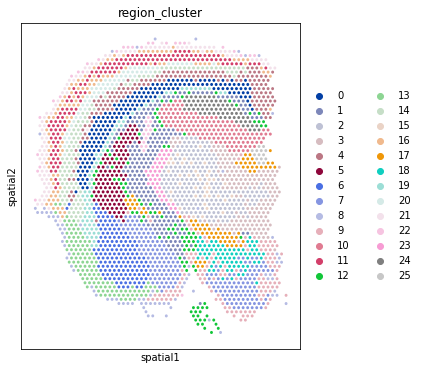

Trying to set attribute `.uns` of view, copying.


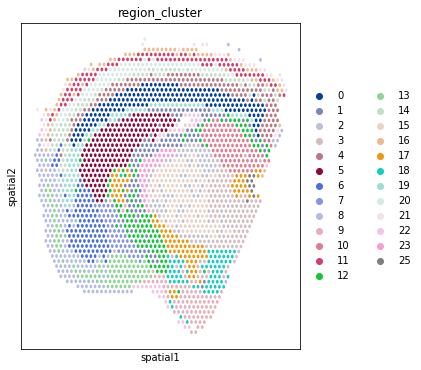

In [8]:
# Plot the region identity of each location in 2D space

with mpl.rc_context({'figure.figsize': (5, 6)}):
    sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059048"], 
                  color=["region_cluster"], img_key=None
                );
    sc.pl.spatial(adata_vis[adata_vis.obs["sample"]=="ST8059051"], 
                  color=["region_cluster"], img_key=None
                )

#### Compare 2D spatial positions to UMAP based on cell densities

Here we use the same KNN graph of location similarity in terms of cell density to perform UMAP projection of all locations. You can see that the regions with analogous position in the cortex (2D above) are composed out of spots coming from both samples (e.g. 13, 4, 16 - cortical layers 1, 2/3, 4).

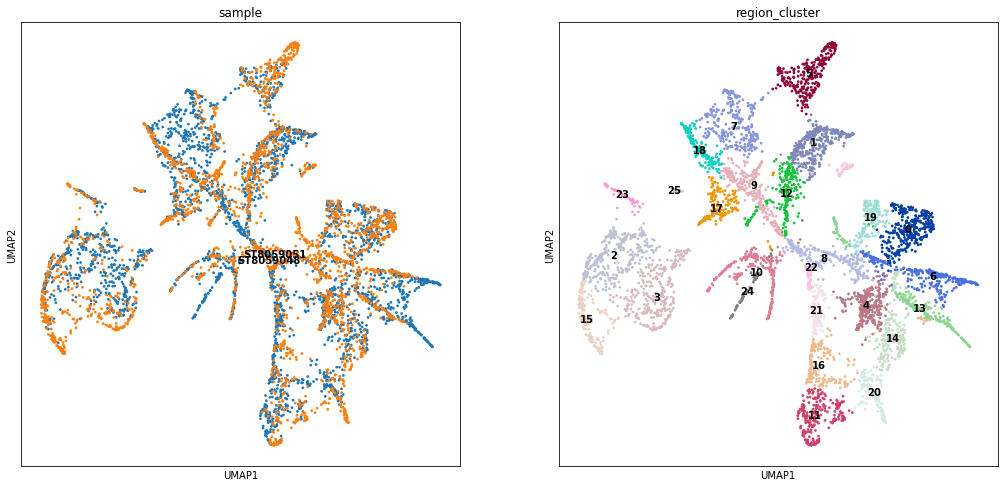

In [9]:
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

with mpl.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(adata_vis, color=['sample', 'region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=10)

#### Export regions for import to 10X Loupe Browser

Our region maps can be visualised over the histology image and explored interactively using the 10X Loupe Browser (please refer to 10X website for instructions).

In [10]:
# save maps for each sample separately
sam = np.array(adata_vis.obs['sample'])
for i in np.unique(sam):
    
    s1 = adata_vis.obs[['region_cluster']]
    s1 = s1.loc[sam == i]
    s1.index = [x[10:] for x in s1.index]
    s1.index.name = 'Barcode'
    
    s1.to_csv(results_folder + 'std_model/'+r['run_name']+'/region_cluster29_' + i + '.csv')

## 4. Identify co-occuring cell type groups using matrix factorisation <a name="5.-Identify-co-occuring-cell-type-groups-using-matrix-factorisation"></a>

Here, we use inferred cell densities as an input to non-negative matrix factorisation to identify co-occuring cell type groups, which can be interpreted as tissue zones or cellular compartments.

If you want to find the most disctinct cell type groups, use a small number of factors.   
If you want to find very strong co-location signal and assume that most cell types don't co-located, use a lot of factors (> 30).

To perform this analysis we first initialise this model and train it several times to evaluate consitency.

In [11]:
# number of cell type combinations - educated guess 
n_fact = int(30)

# extract cell density parameter from cell2location
X_data = adata_vis.uns['mod']['post_sample_means']['spot_factors']

import cell2location.models as c2l
# create model class
mod_sk = c2l.CoLocatedGroupsSklearnNMF(n_fact, X_data, 
        n_iter = 10000,
        verbose = True,
        var_names=adata_vis.uns['mod']['fact_names'],
        obs_names=adata_vis.obs_names,
        fact_names=['fact_' + str(i) for i in range(n_fact)],
        sample_id=None,
        init='random', random_state=0, #alpha=0.1, l1_ratio=0.5,
        nmf_kwd_args={'tol':0.0001})

# train 5 times to evaluate stability
mod_sk.fit(n=5, n_type='restart') 

init_1 - iterations until convergence: 1359
init_2 - iterations until convergence: 1174
init_3 - iterations until convergence: 1306
init_4 - iterations until convergence: 1236
init_5 - iterations until convergence: 1316


Now, let's look at some diagnostic plots. First, you can see that most cell type combinations are consistent between training restarts of this model.

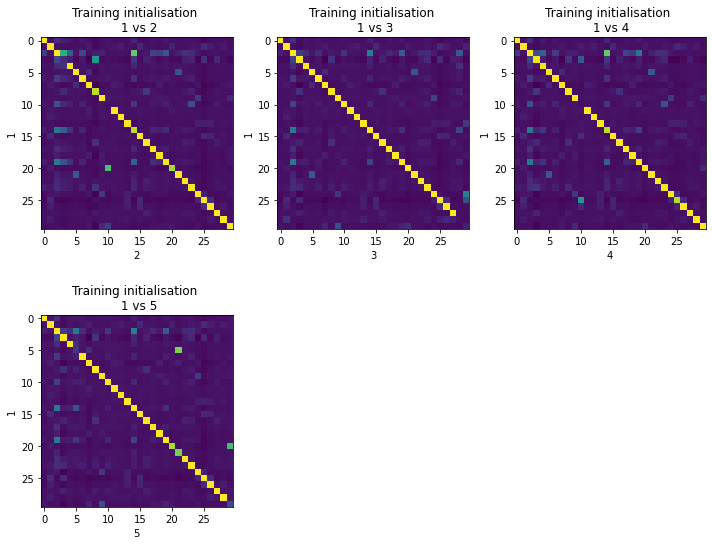

In [12]:
## Do some diagnostics
# evaluate stability by comparing trainin restarts

with mpl.rc_context({'figure.figsize': (10, 8)}):
    mod_sk.evaluate_stability('cell_type_factors', align=True)

Next we evaluate whether the cell type combinations / microenvironments explain the locations of individual cell types well. You should see a strong diagonal 2D histogram comparing the input cell density data (X-axis) and imputed values from the model (Y-axis):

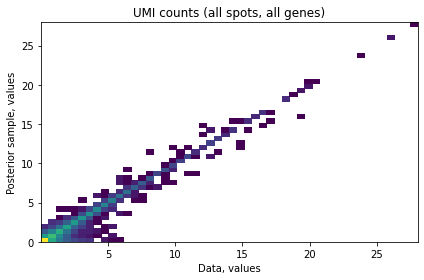

In [13]:
# evaluate accuracy of the model
mod_sk.compute_expected()
mod_sk.plot_posterior_mu_vs_data()

Finally, let's investigate the cell composition of the cell type combinations. We use our model to compute the proportion of each cell type across each combination `'cell_type_fractions'` e.g. 81% of `Astro_2` are found in fact_28. This way we are not biased by the absolute abundance of each cell type.   
Note: factors are exchangeable so while you can find consistent factors, eeach model training will output those factors in a different order.

Here we export this parameters from the model into `adata_vis.uns['mod_sklearn']` spatial anndata object, and print the cell types that contribute most to each combination.

In [14]:
# extract parameters into DataFrames
mod_sk.sample2df(node_name='nUMI_factors', ct_node_name = 'cell_type_factors')

# export results to scanpy object
adata_vis = mod_sk.annotate_adata(adata_vis) # as columns to .obs
adata_vis = mod_sk.export2adata(adata_vis, slot_name='mod_sklearn') # as a slot in .uns

# print the fraction of cells of each type located to each combination
mod_sk.print_gene_loadings(loadings_attr='cell_type_fractions',
                         gene_fact_name='cell_type_fractions')

top-1                 top-2  \
mean_cell_type_factorsfact_0   Ext_Hpc_CA2: 0.95       Astro_HPC: 0.12   
mean_cell_type_factorsfact_1         Unk_1: 0.55            Nb_1: 0.15   
mean_cell_type_factorsfact_2         Inh_4: 0.95           Inh_3: 0.62   
mean_cell_type_factorsfact_3         Ext_L6: 0.9         Inh_Sst: 0.21   
mean_cell_type_factorsfact_4    Ext_Thal_1: 0.99  Astro_THAL_lat: 0.38   
mean_cell_type_factorsfact_5   Inh_Meis2_3: 0.85       Astro_AMY: 0.16   
mean_cell_type_factorsfact_6   Ext_Hpc_CA3: 0.94           Unk_1: 0.11   
mean_cell_type_factorsfact_7         Inh_1: 0.85     Inh_Meis2_1: 0.48   
mean_cell_type_factorsfact_8   Inh_Meis2_4: 0.94  Astro_THAL_lat: 0.16   
mean_cell_type_factorsfact_9       Oligo_2: 0.85           OPC_2: 0.18   
mean_cell_type_factorsfact_10      Ext_Pir: 0.95      Astro_AMY: 0.056   
mean_cell_type_factorsfact_11  Ext_Hpc_DG2: 0.91     Ext_Hpc_DG1: 0.86   
mean_cell_type_factorsfact_12       LowQ_1: 0.94       Astro_WM: 0.063   
mean_cell_type_factorsfact_13  Ext_Hpc_CA1: 0.93          Unk_1: 0.022   
mean_cell_type_factorsfact_14      Ext_L25: 0.96       Astro_CTX: 0.24   
mean_cell_type_factorsfact_15        Inh_6: 0.97  Astro_THAL_hab: 0.19   
mean_cell_type_factorsfact_16      Oligo_1: 0.84           OPC_2: 0.44   
mean_cell_type_factorsfact_17      Ext_L6B: 0.96        Ext_L5_3: 0.59   
mean_cell_type_factorsfact_18  Inh_Meis2_2: 0.92     Inh_Meis2_3: 0.15   
mean_cell_type_factorsfact_19      Ext_L56: 0.89        Ext_Med: 0.086   
mean_cell_type_factorsfact_20      Ext_L23: 0.95         Inh_Vip: 0.18   
mean_cell_type_factorsfact_21    Inh_Pvalb: 0.84         Ext_Med: 0.13   
mean_cell_type_factorsfact_22   Ext_Thal_2: 0.97       Ext_Unk_3: 0.36   
mean_cell_type_factorsfact_23         Nb_2: 0.73        Astro_WM: 0.65   
mean_cell_type_factorsfact_24    Ext_Amy_2: 0.95         Inh_Vip: 0.15   
mean_cell_type_factorsfact_25        Inh_2: 0.99           Inh_5: 0.55   
mean_cell_type_factorsfact_26     Ext_L5_1: 0.92           LowQ_2: 0.1   
mean_cell_type_factorsfact_27  Ext_ClauPyr: 0.95      Astro_CTX: 0.034   
mean_cell_type_factorsfact_28    Ext_Amy_1: 0.95       Ext_Unk_1: 0.49   
mean_cell_type_factorsfact_29     Ext_L5_2: 0.98          LowQ_2: 0.58   

                                               top-3                  top-4  \
mean_cell_type_factorsfact_0      Ext_Hpc_DG1: 0.069           Unk_1: 0.063   
mean_cell_type_factorsfact_1         Astro_AMY: 0.14          Inh_Sst: 0.12   
mean_cell_type_factorsfact_2        Astro_HYPO: 0.49        Ext_Unk_2: 0.47   
mean_cell_type_factorsfact_3         Ext_L5_3: 0.074          LowQ_2: 0.068   
mean_cell_type_factorsfact_4    Astro_THAL_med: 0.26       Ext_Unk_3: 0.052   
mean_cell_type_factorsfact_5       Inh_Meis2_1: 0.13        Astro_STR: 0.13   
mean_cell_type_factorsfact_6        Astro_HPC: 0.023           Unk_2: 0.019   
mean_cell_type_factorsfact_7          Ext_Unk_1: 0.1       Astro_AMY: 0.081   
mean_cell_type_factorsfact_8   Astro_THAL_med: 0.065  Astro_THAL_hab: 0.063   
mean_cell_type_factorsfact_9    Astro_THAL_hab: 0.15         Astro_WM: 0.15   
mean_cell_type_factorsfact_10     Inh_Meis2_1: 0.041       Ext_Unk_2: 0.039   
mean_cell_type_factorsfact_11             Nb_1: 0.22            Nb_2: 0.074   
mean_cell_type_factorsfact_12            Endo: 0.048            Unk_2: 0.02   
mean_cell_type_factorsfact_13       Inh_Lamp5: 0.019       Astro_STR: 0.018   
mean_cell_type_factorsfact_14          Ext_Med: 0.19       Astro_HPC: 0.083   
mean_cell_type_factorsfact_15        Astro_WM: 0.052           Unk_2: 0.028   
mean_cell_type_factorsfact_16       Ext_Unk_3: 0.084           OPC_1: 0.056   
mean_cell_type_factorsfact_17          Inh_Vip: 0.13          Inh_Sst: 0.11   
mean_cell_type_factorsfact_18        Astro_STR: 0.11       Astro_HPC: 0.069   
mean_cell_type_factorsfact_19       Astro_STR: 0.083       Astro_CTX: 0.078   
mean_cell_type_factorsfact_20        Inh_Lamp5: 0.15          Ext_Med: 0.12   
mean_cell_

A convenient way to explore the composition of cell type combinations / microenvironments is by using a heatmap:

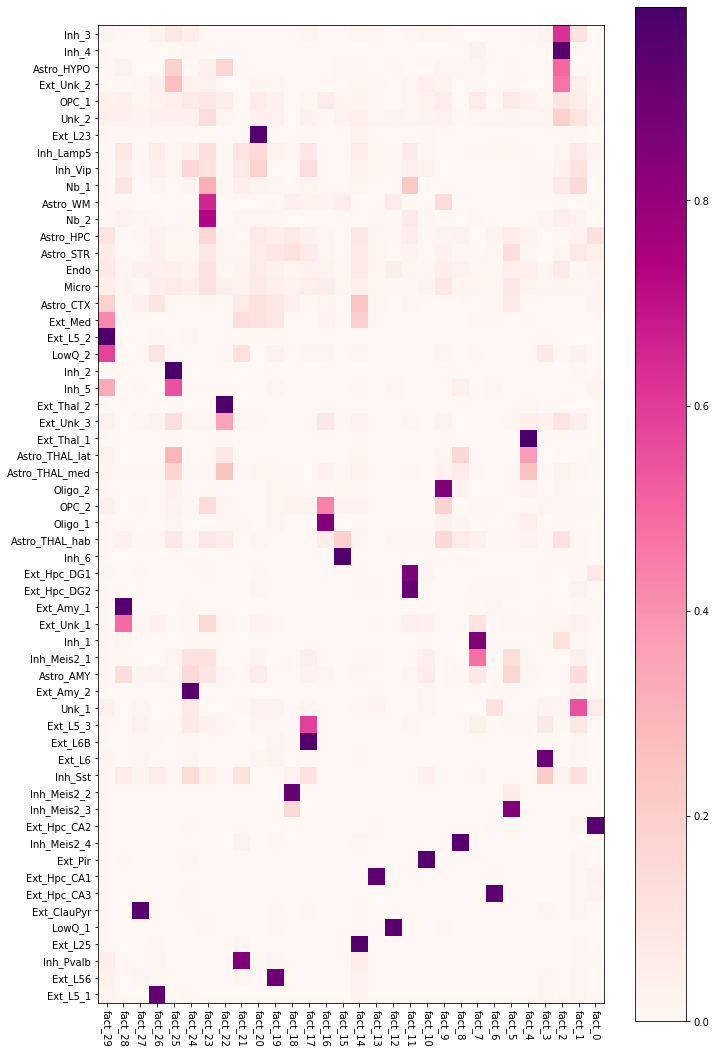

In [15]:
# make nice names
from re import sub
mod_sk.cell_type_fractions.columns = [sub('mean_cell_type_factors', '', i) 
                                      for i in mod_sk.cell_type_fractions.columns]

# plot co-occuring cell type combinations
mod_sk.plot_gene_loadings(mod_sk.var_names_read, mod_sk.var_names_read,
                        fact_filt=mod_sk.fact_filt,
                        loadings_attr='cell_type_fractions',
                        gene_fact_name='cell_type_fractions',
                        cmap='RdPu', figsize=[10, 15])

Finally we need to examine where in the tissue each cell type combination / microenvironment is located:

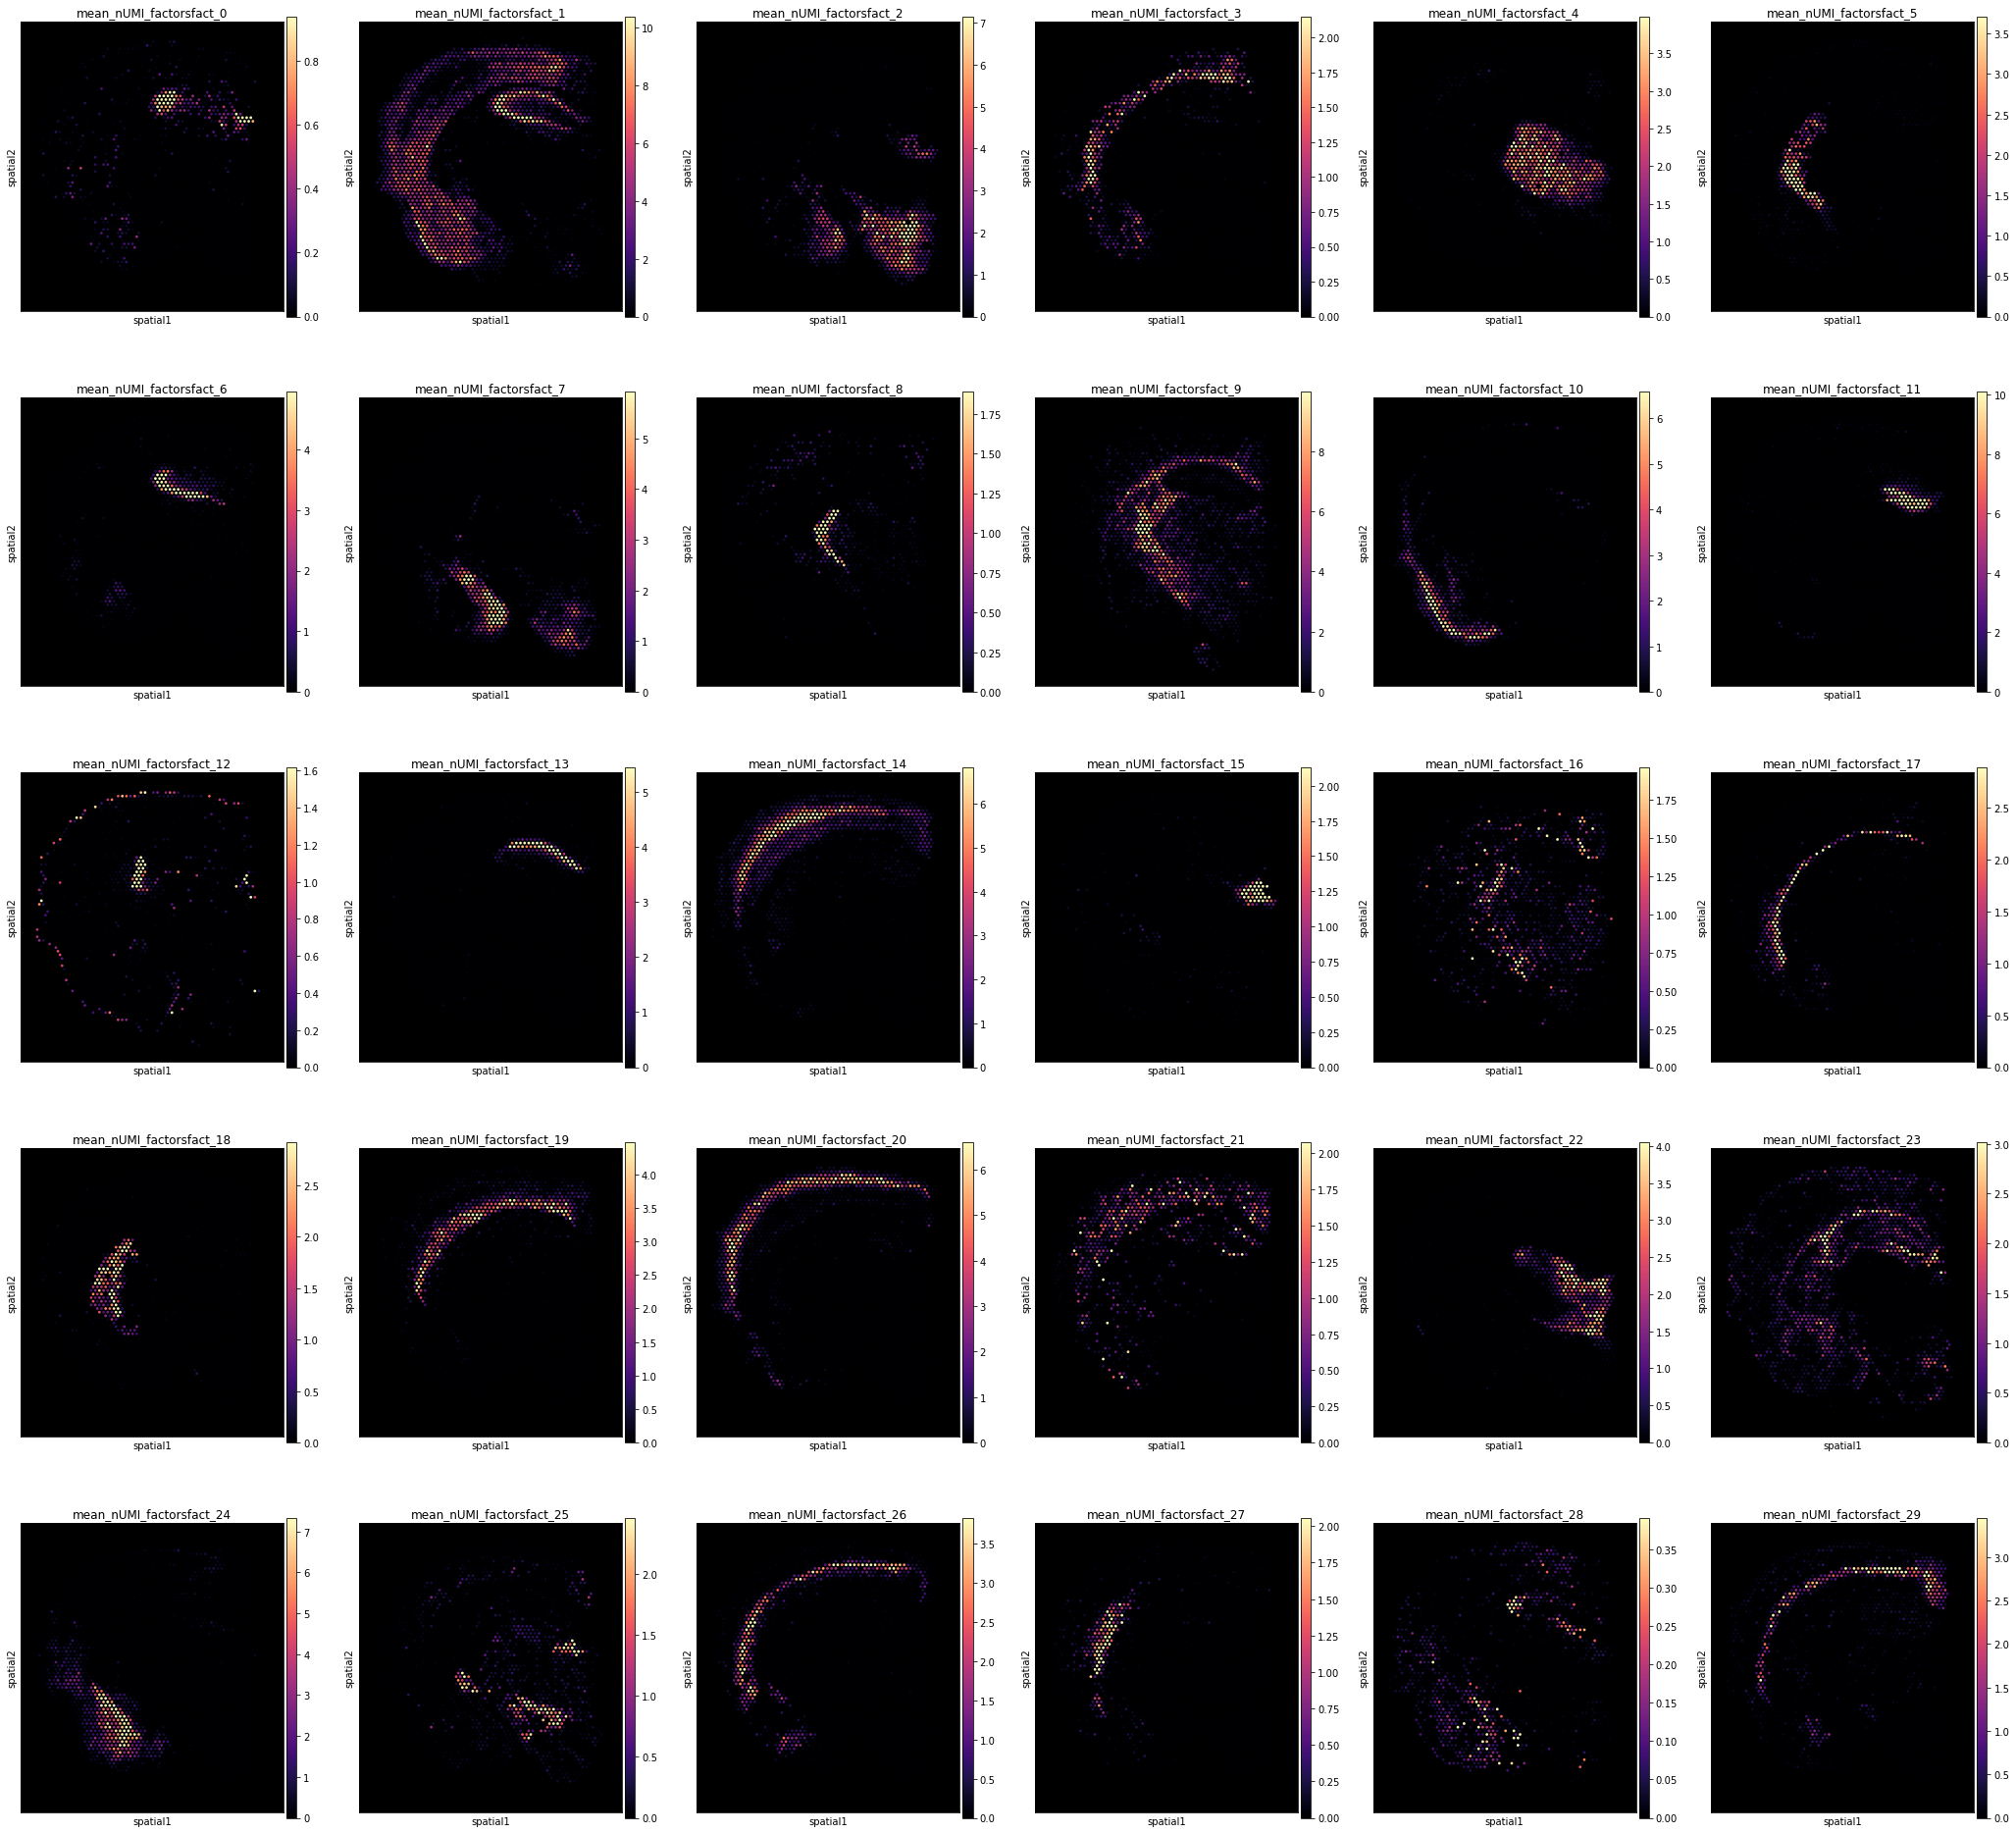

In [16]:
# plot cell density in each combination
with mpl.rc_context({'figure.figsize': (5, 6), 'axes.facecolor': 'black'}):
    sc.pl.spatial(adata_vis[adata_vis.obs['sample'].isin([adata_vis.obs['sample'].unique()[0]]),:],
                  cmap='magma', library_id=list(adata_vis.uns['spatial'].keys())[0],
                  color=mod_sk.location_factors_df.columns,
                  ncols=6, 
                  size=1, img_key='hires', 
                  alpha_img=0,
                  vmin=0, vmax='p99.2'
                 )

Now we save the co-location models object:

In [17]:
# save co-location models object
def pickle_model(mod, path, file_suffix=''):
    file = path + 'model_' + str(mod.__class__.__name__) + '_' + str(mod.n_fact) + '_' + file_suffix + ".p"
    pickle.dump({'mod': mod, 'fact_names': mod.fact_names}, file = open(file, "wb"))
    print(file)
    
pickle_model(mod_sk, results_folder + 'std_model/'+r['run_name'] + '/', file_suffix='')

/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/std_model/LocationModelLinearDependentWMultiExperiment_58clusters_5396locations_12809genes/model_CoLocatedGroupsSklearnNMF_30_.p


### It is often useful to vary the number of cell type groups to select most meaningful

To aid this we wrapped the analysis shown here into a pipeline that automates training the NMF model with varying number of factors (including export of the same plots and data as shown above).

```python
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
                   adata_vis, model_name='CoLocatedGroupsSklearnNMF',
                   verbose=False, return_all=True,
    
                   train_args={
                    'n_fact': np.arange(10, 40), # IMPORTANT: range of number of factors (10-40 here)
                    'n_iter': 20000, # maximum number of training iterations
                       
                    'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
                       
                    'mode': 'normal',
                    'n_type': 'restart', 'n_restarts': 5 # number of training restarts
                   },
    
                   model_kwargs={'init': 'random', 'random_state': 0, 'nmf_kwd_args': {'tol': 0.00001}},
    
                   posterior_args={},
                   export_args={'path': results_folder + 'std_model/'+r['run_name']+'/CoLocatedComb/',
                                'run_name_suffix': ''}) 
```

## 5. Visualize cell type density gradients using diffusion maps <a name="5.-Visualize-cell-type-density-gradients-using-diffusion-maps"></a>

While grouping cells into discrete regions is suitable for tissues with highly-stereotyped anatomy (e.g. the brain where the anatomical boundaries of tissue regions are highly conserved from one individual to next), many tissues are characterised by continuously changing cell type densities, driven by specific signals from other cells. To aid the investigation of dynamic tissue architecture, we propose using diffusion maps and non-negative matrix factorisation:

1. Diffusion maps approach to infer cell type density gradients: this method describes the transitions in cell composition through the tissue space and shows which tissue regions are connected in terms of their cell composition. 
2. NMF approach to find combinations of co-located cell types and regulatory programmes: these can be thought of as microenvironments with distinct composition. Unlike discrete region clustering this allows the co-location signal to change continuously, and allows partial overlap in location of distinct microenvironments.

First, we perform the diffusion map representation, which is constructed from the same KNN graph and region clustering (see above) using `sc.tl.diffmap`. See `help(sc.tl.diffmap)` for details.

In [18]:
sc.tl.diffmap(adata_vis)

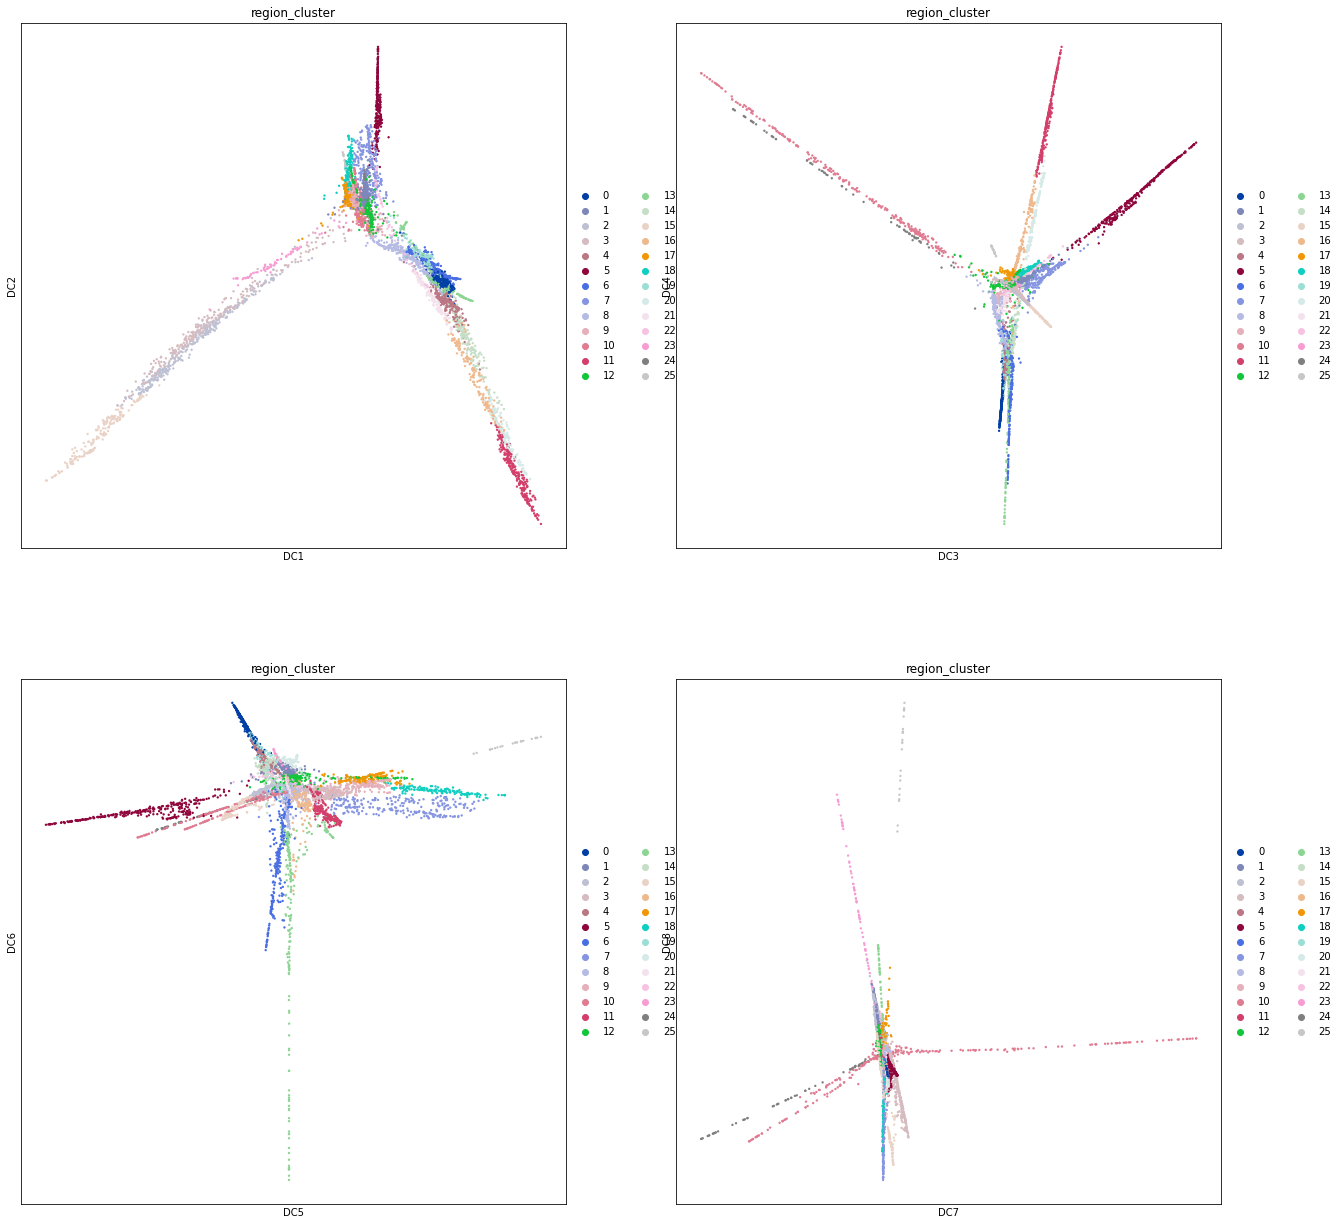

In [19]:
with mpl.rc_context({'figure.figsize': (10, 10)}):
    sc.pl.diffmap(adata_vis, color=['region_cluster'],
                  components=['1,2', '3,4', '5,6', '7,8'], ncols=2)

## Export results

Save resulting adata with clustering, diffusion maps and co-occuring cell type combinations.

In [20]:
adata_file = results_folder \
                + 'std_model/'+r['run_name']+'/sp_with_clusters.h5ad'
adata_vis.write(adata_file)
adata_file

'/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/std_model/LocationModelLinearDependentWMultiExperiment_58clusters_5396locations_12809genes/sp_with_clusters.h5ad'

Modules and their versions used for this analysis

In [21]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass


sys 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.18.1
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
tornado 6.0.4
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 